<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/MultiphaseflowMeasurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Multiphase flow measurements
#@markdown This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
%matplotlib inline

# Multiphase flow measurement
A multiphase flow meter is a device used to measure the individual phase flow rates of constituent phases in a given flow (for example in oil and gas industry) where oil, water and gas mixtures are initially co-mingled together during the oil production processes.

# Litterature

Wikipedia

https://en.wikipedia.org/wiki/Multiphase_flow_meter


HANDBOOK OF MULTIPHASE FLOW METERING:

https://nfogm.no/wp-content/uploads/2014/02/MPFM_Handbook_Revision2_2005_ISBN-82-91341-89-3.pdf

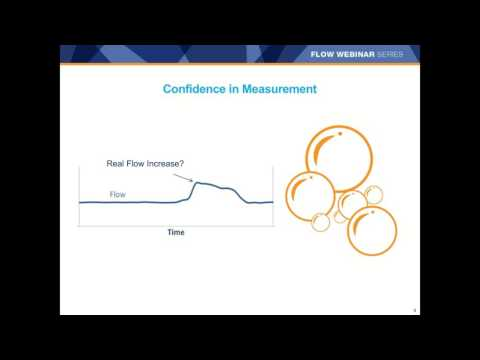

In [33]:
#@title Webinar: Advances in Multiphase Metering for Onshore Measurement in Oil & Gas
#@markdown This video gives an intriduction to Oil & Gas facilities Design
from IPython.display import YouTubeVideo
YouTubeVideo('mcxrjJwidl0', width=600, height=400)

# Calculation of PVT properties for a multiphase flow meter

A typical multi phase flow meter will need calclation of various thermodynamic and physical properties. SUch properties have to be updated s the field is produced. The input to the property calculations are a characterized fluid composition from PVT studies.

The following script demonstrates calculation of PVT properties for a multi phase flow meter using a CHaracterized fluid composition.

                          total          gas          oil                     
           nitrogen  9.62745E-3   9.62745E-3   9.62745E-3      [mole fraction]
                CO2  6.83819E-3   6.83819E-3   6.83819E-3      [mole fraction]
            methane  9.49258E-1   9.49258E-1   9.49258E-1      [mole fraction]
             ethane  2.58432E-2   2.58432E-2   2.58432E-2      [mole fraction]
            propane   1.1397E-3    1.1397E-3    1.1397E-3      [mole fraction]
           i-butane  1.45961E-3   1.45961E-3   1.45961E-3      [mole fraction]
           n-butane  2.39936E-4   2.39936E-4   2.39936E-4      [mole fraction]
          i-pentane  7.79793E-4   7.79793E-4   7.79793E-4      [mole fraction]
          n-pentane  2.19942E-4   2.19942E-4   2.19942E-4      [mole fraction]
              C6_PC  6.59825E-4   6.59825E-4   6.59825E-4      [mole fraction]
              C7_PC  1.10971E-3   1.10971E-3   1.10971E-3      [mole fraction]
              C8_PC  1.06972E-3   1.06972E-3   1.069

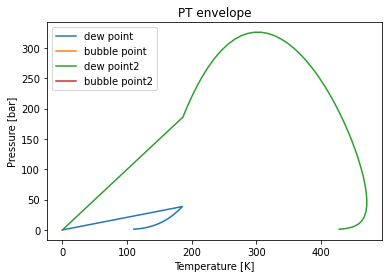

JavaObject id=o4182

In [66]:
names = ['nitrogen','CO2', 'methane', 'ethane', 'propane','i-butane','n-butane','i-pentane','n-pentane']
molefractions = [0.963, 0.684, 94.951, 2.585, 0.114, 0.146, 0.024, 0.078, 0.022]
fluidDefinedComponents = createfluid2(names, molefractions, "mol/sec")

charNames = ["C6", "C7", "C8", "C9", "C10"]
charFlowrate = [0.066, 0.111, 0.107, 0.047, 0.1285]
molarMass = [86.18/1000.0, 96.0/1000.0, 107.0/1000.0, 121.0/1000.0, 190.0/1000.0]
density = [664.0e-3, 738.0e-3, 765.0e-3, 781.0e-3, 832.10e-3]
characterizedFluid = addOilFractions(fluidDefinedComponents, charNames,charFlowrate,molarMass,  density);
characterizedFluid.setHeavyTBPfractionAsPlusFraction()
characterizedFluid.getCharacterization().getLumpingModel().setNumberOfPseudoComponents(12);
characterizedFluid.getCharacterization().setLumpingModel("PVTlumpingModel");
characterizedFluid.getCharacterization().characterisePlusFraction();
characterizedFluid.setMixingRule(2)
characterizedFluid.init(0)
characterizedFluid
printFrame(characterizedFluid)
characterizedFluid.setTemperature(273.15+20.6)
characterizedFluid.setPressure(86.8)
TPflash(characterizedFluid)

GORcalc = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
print("GOR ", GORcalc)
print('phase envelope for characterized fluid')
phaseenvelope(characterizedFluid, True)

## Generation of properties for multiphase measurements

The following script demonstrates how to generate typical properties for a multiphase flow meter.

In [44]:
import numpy
import numpy as np

pressures = [150.0, 170.0, 180.0, 200.0, 270.0, 320.0, 400.0]
temperatures = [30.0, 40.0, 50.0, 60.0, 80.0]

numP = len(pressures)
numT = len(temperatures)

gasViscosity = numpy.zeros((numP, numT))
oilViscosity = numpy.zeros((numP, numT))
gasDensity = numpy.zeros((numP, numT))
oilDensity = numpy.zeros((numP, numT))
GORcalc  = numpy.zeros((numP, numT))
GORactual = numpy.zeros((numP, numT))
gasViscosity[:] = np.NaN
oilViscosity[:] = np.NaN
gasDensity[:] = np.NaN
oilDensity[:] = np.NaN
GORcalc[:] = np.NaN
GORactual[:] = np.NaN

for i in range(len(temperatures)):
  for j in range(len(pressures)):
    characterizedFluid.setPressure(pressures[j])
    characterizedFluid.setTemperature(temperatures[i]+273.15)
    TPflash(characterizedFluid)
    characterizedFluid.initProperties()
    if(characterizedFluid.hasPhaseType("gas")):
      gasViscosity[j][i]=characterizedFluid.getPhase("gas").getViscosity("cP")
      gasDensity[j][i]=characterizedFluid.getPhase("gas").getDensity("kg/m3")
    if(characterizedFluid.hasPhaseType("oil")):
      oilViscosity[j][i]=characterizedFluid.getPhase("oil").getViscosity("cP")
      oilDensity[j][i]=characterizedFluid.getPhase("oil").getDensity("kg/m3")
    if(characterizedFluid.hasPhaseType("gas") and characterizedFluid.hasPhaseType("oil")):
      GORcalc[j][i] = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
      GORactual[j][i] =   (characterizedFluid.getPhase("gas").getVolume("m3"))/ (characterizedFluid.getPhase("oil").getVolume("m3"))

gasDensityDataFrame = pd.DataFrame(gasDensity,index=pressures, columns=temperatures)
oilDensityDataFrame = pd.DataFrame(oilDensity,index=pressures, columns=temperatures)
gasviscosityDataFrame = pd.DataFrame(gasViscosity,index=pressures, columns=temperatures)
oilviscosityDataFrame = pd.DataFrame(oilViscosity,index=pressures, columns=temperatures)
GORcalcFrame = pd.DataFrame(GORcalc,index=pressures, columns=temperatures)
GORactualFrame = pd.DataFrame(GORactual,index=pressures, columns=temperatures)

print("gas density")
print(gasDensityDataFrame.tail())
print("oil density")
print(oilDensityDataFrame.head())
print("gas viscosity")
print(gasviscosityDataFrame.tail())
print("oil viscosity")
print(oilviscosityDataFrame.head())
print("GOR actual")
print(GORactualFrame.head())

gas density
             30.0        40.0        50.0        60.0        80.0
180.0  147.193249  138.816622  131.512851  125.088659  114.296612
200.0  162.450946  153.375058  145.393266  138.330315  126.399816
270.0  207.339261  197.150419  187.885768  179.463285  164.805285
320.0  232.715540  222.477873  212.490767  203.740641  188.188762
400.0  263.277575  253.489276  244.232392  235.503166  219.570908
oil density
             30.0        40.0        50.0        60.0        80.0
150.0  711.470653  715.877288  720.338478  724.811625  733.667056
170.0  710.384750  714.698183  719.141616  723.653059  732.749568
180.0  710.676996  714.871380  719.248072  723.735027  732.901984
200.0  712.878797  716.714566  720.860543  725.226108  734.453416
270.0  736.720518  738.499722  741.146250  744.498583  752.826753
gas viscosity
           30.0      40.0      50.0      60.0      80.0
180.0  0.018388  0.018125  0.017956  0.017858  0.017815
200.0  0.019574  0.019201  0.018937  0.018758  0.018586
27

# Test the fluid characterisation by comparing to PVT data
The bubble point pressure is determined by an experiment called Constant Composition Expansion (CCE). It's also called Constant Mass Expansion (CME) experiment or Pressure-Volume (PV) relationship. ... The cell pressure is controlled by a positive displacement pump and recorded on an accurate pressure gauge.

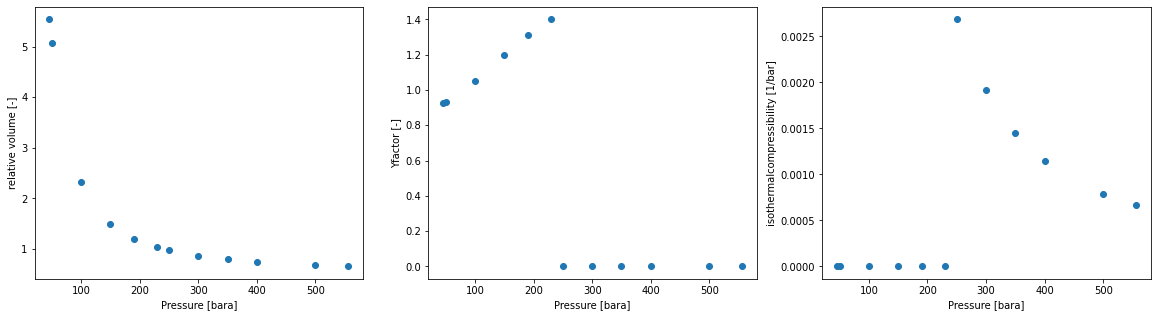

YfactorFrame
       relativevolume   Yfactor      Zgas  isothermalcompressibility  liquidrelativevolume
555.3        0.653787  0.000000  1.287685                   0.000663              0.000000
500.0        0.680418  0.000000  1.206679                   0.000787              0.000000
400.0        0.748124  0.000000  1.061401                   0.001148              0.000000
350.0        0.797965  0.000000  0.990599                   0.001451              0.000000
300.0        0.867280  0.000000  0.922841                   0.001916              0.000000
250.0        0.971343  0.000000  0.861308                   0.002686              0.000000
230.0        1.031336  1.399919  0.000000                   0.000000              0.155316
190.0        1.201313  1.309544  0.000000                   0.000000              0.342957
150.0        1.501135  1.198472  0.000000                   0.000000              0.595781
100.0        2.331090  1.052442  0.000000                   0.000000         

In [67]:

pressure = [555.3, 500.0, 400.0, 350.0, 300.0, 250.0, 230.0, 190.0, 150.0, 100.0, 50.0, 46.1]
temperature = [273.15+73.0, 273.15+73.0, 273.15+73.0, 273.15+73.0, 273.15+73.0, 273.15+73.0, 273.15+73.0, 273.15+73.0, 273.15+73.0, 273.15+73.0, 273.15+73.0, 273.15+73.0]

relativevolume = []
liquidrelativevolume = []
Zgas =  []
Yfactor = []
isothermalcompressibility = []

CME(characterizedFluid,pressure,temperature,relativevolume, liquidrelativevolume,Zgas,Yfactor,isothermalcompressibility)

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(pressure, relativevolume, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('relative volume [-]')
plt.subplot(132)
plt.plot(pressure, Yfactor, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('Yfactor [-]')
plt.subplot(133)
plt.plot(pressure, isothermalcompressibility, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('isothermalcompressibility [1/bar]')
plt.show()

Yfactorarray= np.asarray([relativevolume,Yfactor,Zgas, isothermalcompressibility,liquidrelativevolume])
pressurearray= np.asarray(pressure)
temperaturearray= np.asarray(temperature)
YfactorFrame = pd.DataFrame(Yfactorarray.transpose(),index=pressurearray, columns=["relativevolume", "Yfactor", "Zgas", "isothermalcompressibility", "liquidrelativevolume"])
print("YfactorFrame")
print(YfactorFrame.head(20).to_string())
print()